In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
import glob
import os

from pyquaternion import Quaternion
from panorama_to_pinhole import *
from Pano_Utils import *

In [2]:
import open3d as o3d
from pyntcloud import PyntCloud
import pye57

# 1. Load panorama

load the panorama image and its corresponding depth data

In [26]:
dataset_path = "../Raw/"
pano_images = glob.glob(dataset_path+"/picture/*.jpg")
pano_scans = glob.glob(dataset_path+"/*.e57")
pano_scans.sort()
print(len(pano_images), len(pano_scans))

266 133


In [4]:
points, colors, R_scan, t_scan = read_e57_with_pose(pano_scans[0])

In [21]:
image_path = dataset_path + "picture/" +pano_scans[0][pano_scans[0].find("garden_"):-4]+".jpg"
panorama_img_raw = imageio.imread(image_path)[:, :, :3]
panorama_img = np.zeros([int(panorama_img_raw.shape[1]/2), panorama_img_raw.shape[1], 3]).astype(np.uint8)
panorama_img[0:panorama_img_raw.shape[0],:,:] = panorama_img_raw
panorama_sampler = panorama_to_sampler(panorama_img)

In [5]:
point_cloud_o3d_2 = o3d.geometry.PointCloud()
point_cloud_o3d_2.points = o3d.utility.Vector3dVector(points)
point_cloud_o3d_2.colors = o3d.utility.Vector3dVector(colors/255)

o3d.visualization.draw_geometries([point_cloud_o3d_2])

In [6]:
image, depth = project_points_to_panorama(points, colors, 1200)

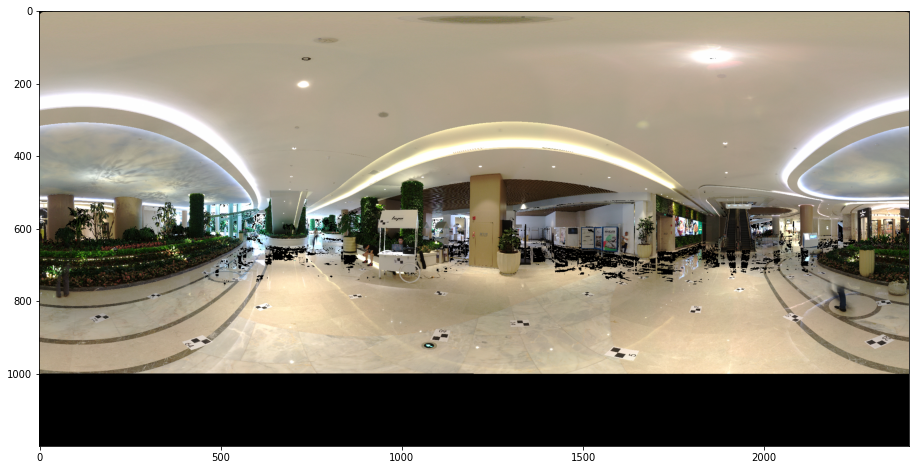

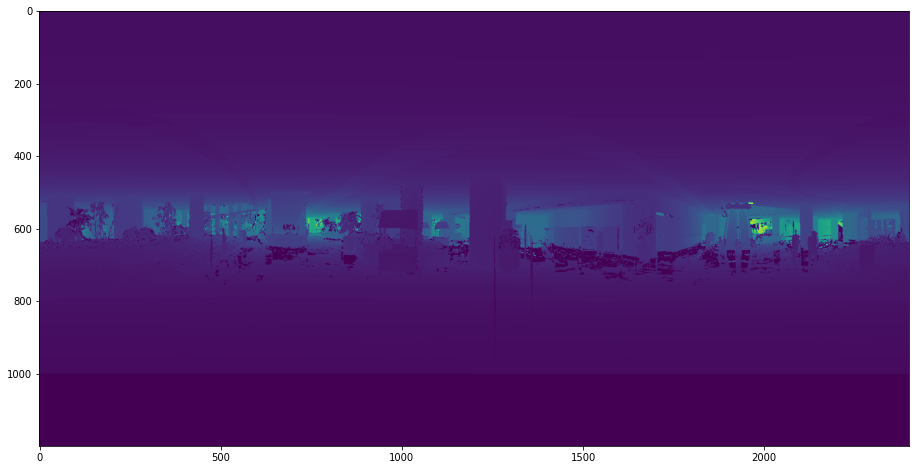

In [7]:
plt.figure(figsize=(16,8))
plt.imshow(image)
plt.figure(figsize=(16,8))
plt.imshow(depth)

im_save = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## 2. Make pinhold RGBD

In [13]:
def make_data_set_for_scan(points, panorama_sampler, save_folder, camera_mtx, fov = 60):
    num_image = int(np.ceil(360 / fov))
    
    file_camera_mtx = open(save_folder + "/camera_matrix.txt", "w")
    str_cam_mtx = str(camera_mtx[0,0]) + " " + str(camera_mtx[1,1]) + " " + str(camera_mtx[0,2]) + " " + str(camera_mtx[1,2])
    file_camera_mtx.write(str_cam_mtx)
    file_camera_mtx.close()
    
    file_poses = open(save_folder + "/camera_local_poses.txt", "w")
    focal = camera_mtx[0,0]
    for i in range(num_image):
        angle = fov * i;
    
        rot_angles_rad = np.deg2rad(np.array([0, angle, 0]))
        R = R_cam_to_world(*rot_angles_rad)
        pose = np.eye(4)
        pose[0:3,0:3] = np.transpose(R)
        
        str_pose = str(i+1)
        for k in range(4):
            for j in range(4):
                str_pose  = str_pose + ' ' + str(pose[k,j])
        str_pose += '\n'
        file_poses.write(str_pose)
    
        image_pinhole = panorama_to_pinhole(panorama_sampler, res, focal, [0, angle, 0])
        image_show = image_pinhole #[int(res[1]/2-width/2)+offset:int(res[1]/2+width/2)+offset,:,:]

        depth_show = get_depth_pinhole(points, camera_mtx, (480,640), pose)

        image_show = cv2.cvtColor(image_show, cv2.COLOR_BGR2RGB) 
        cv2.imwrite(save_folder+"/"+str(i+1)+"_r.jpg", image_show)
        cv2.imwrite(save_folder+"/"+str(i+1)+"_d.jpg", cv2.applyColorMap(cv2.convertScaleAbs(depth_show,alpha=15),cv2.COLORMAP_JET))
        np.save(save_folder+"/"+str(i+1)+"_d.npy", depth_show)
    file_poses.close()

In [10]:
dataset_path = "../Raw/"
save_folder = "../RGBD/"
pano_scans = glob.glob(dataset_path+"/*.e57")
pano_scans.sort()
print(len(pano_scans))

133


In [61]:
# initialize camera model
res = (640, 480)
focal = 500
width = res[0]*480/640
offset = 0
camera_mtx = np.array([
    [focal, 0, res[0]/2],
    [0,focal, res[1]/2],
    [0,0,1]
])


# save scans
for pano_scan in pano_scans:
    tmp = 4086
    output_shape = (tmp, tmp*2)
    
    scan_name = pano_scan[pano_scan.find("garden_"):-4]
    image_path = dataset_path + "picture/" +scan_name+".jpg"
    panorama_img_raw = imageio.imread(image_path)[:, :, :3]
    panorama_img = np.zeros([output_shape[0], output_shape[1], 3]).astype(np.uint8)
    if(panorama_img.shape[1] < panorama_img_raw.shape[1]):
        panorama_img[0:panorama_img_raw.shape[0],:,:] = panorama_img_raw[:,:panorama_img.shape[1],:]
    else:
        panorama_img[0:panorama_img_raw.shape[0],0:panorama_img_raw.shape[1],:] = panorama_img_raw[:,:,:]
    panorama_sampler = panorama_to_sampler(panorama_img)
    
    points, colors, R_scan, t_scan = read_e57_with_pose(pano_scan)
    
    curr_folder = save_folder + scan_name
    commend = "mkdir " + curr_folder
    os.system(commend)
    
    file_scan_pose = open(curr_folder + "/scan_pose.txt", "w")
    file_scan_pose.write(str(R_scan))
    file_scan_pose.write("\n")
    file_scan_pose.write(str(t_scan))
    file_scan_pose.close()
    
    make_data_set_for_scan(points, panorama_sampler, curr_folder, camera_mtx, fov = 40)

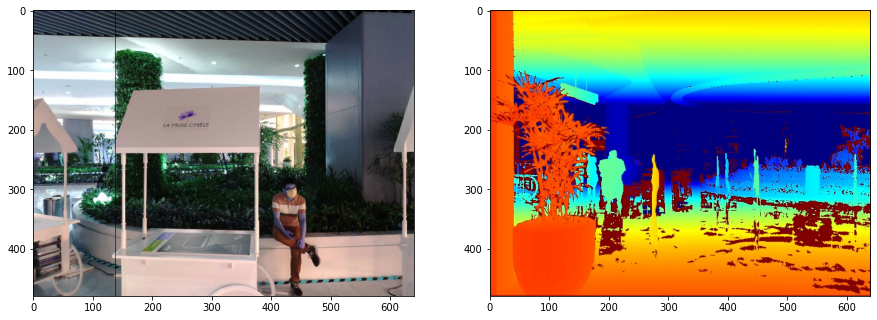

In [63]:
problematic_images = []
problematic_images.append("../RGBD/garden_20200817035/6_r.jpg")
problematic_images.append("../RGBD/garden_20200817026/8_d.jpg")

plt.figure(figsize=(15,10))
for i in range(len(problematic_images)):
    img = cv2.imread(problematic_images[i])
    plt.subplot(1,len(problematic_images), (i+1))
    plt.imshow(img)